# **Conditional Variational autoencoder (VAE) - Toy datasets**

# **Utility functions**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
print(tf. __version__)

2.7.0


In [2]:
import datetime, os


In [3]:
K.clear_session()

In [4]:
def find_indices(lst, condition):
    return np.array([i for i, elem in enumerate(lst) if condition(elem)])
    
def plot_2d_data_categorical(data_2d, y, titles=None, figsize = (7, 7), category_count=10):
  fig, axs = plt.subplots(category_count, len(data_2d), figsize = figsize)
  colors = np.array(['#7FFFD4', '#458B74', '#0000CD', '#EE3B3B', '#7AC5CD', '#66CD00',
         '#EE7621', '#3D59AB', '#CD950C', '#483D8B'])
  for i in range(len(data_2d)):
      for k in range(category_count):

        index = find_indices(y[i], lambda e: e == k)

        data_2d_k = data_2d[i][index, ]
        y_k = y[i][index]

        if (titles != None):
          axs[k,i].set_title("{} - Class: {}".format(titles[i], k))

        scatter = axs[k, i].scatter(data_2d_k[:, 0], data_2d_k[:, 1],
                                s=1, c=colors[k], cmap=plt.cm.Paired)
        axs[k, i].legend(*scatter.legend_elements())
        axs[k, i].set_xlim([-3, 3])
        axs[k, i].set_ylim([-3, 3])
        wandb.log({"Embdedding_classes": wandb.Image(plt)})
        fig.savefig('reports/' + directory + '/encoding_categorical')
        
def plot_2d_data(data_2d, y, titles=None, figsize = (7, 7)):
  _, axs = plt.subplots(1, len(data_2d), figsize = figsize)

  for i in range(len(data_2d)):
    
    if (titles != None):
      axs[i].set_title(titles[i])
    scatter=axs[i].scatter(data_2d[i][:, 0], data_2d[i][:, 1],
                            s=1, c=y[i], cmap=plt.cm.Paired)
    axs[i].legend(*scatter.legend_elements())
    wandb.log({"Embdedding": wandb.Image(plt)})

def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],
                  label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],
                  label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),
              max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],
                    label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],
                    label='val_'+metric,color = line2.get_color(),
                    linestyle = '--')
    ax2.set_ylim([0, max(max(history.history[metric]),
                max(history.history['val_'+metric]))])
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

def plot_generated_images(generated_images, nrows, ncols, digit_label,
                          no_space_between_plots=False, figsize=(10, 10)):
  _, axs = plt.subplots(nrows, ncols,figsize=figsize,squeeze=False)

  for i in range(nrows):
    for j in range(ncols):
      axs[i,j].axis('off')
      axs[i,j].imshow(generated_images[i][j], cmap='gray')

  if no_space_between_plots:
    plt.subplots_adjust(wspace=0,hspace=0)
  
  wandb.log({"Latent_interpolation_class: {}".format(digit_label): wandb.Image(plt)})

  plt.show()



In [5]:
def conditional_input(self, inputs, label_size=10):
    image_size = [self.shape[0], self.shape[1], self.shape[2]]
    input_img = layers.InputLayer(input_shape=image_size,
                                dtype ='float32')(inputs[0])
    input_label = layers.InputLayer(input_shape=(label_size, ),
                                    dtype ='float32')(inputs[1])
    labels = tf.reshape(inputs[1], [-1, 1, 1, label_size])
    labels = tf.cast(labels, dtype='float32')
    ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size])
    labels = ones * labels
    conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
    return  input_img, input_label, conditional_input

In [6]:
def sampling(z_mean, z_log_var, input_label):

    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32,
                            mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    z_cond = tf.concat([z, input_label], axis=1) 
    return z_cond

In [7]:
def Train_Val_Plot(loss, val_loss, reconstruction_loss, val_reconstruction_loss, kl_loss, val_kl_loss):

    fig, (ax1, ax2, ax3) = plt.subplots(1,4, figsize= (16,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(loss) + 1), loss)
    ax1.plot(range(1, len(val_loss) + 1), val_loss)
    ax1.set_title('History of Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(reconstruction_loss) + 1), reconstruction_loss)
    ax2.plot(range(1, len(val_reconstruction_loss) + 1), val_reconstruction_loss)
    ax2.set_title('History of reconstruction_loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('reconstruction_loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(kl_loss) + 1), kl_loss)
    ax3.plot(range(1, len(val_kl_loss) + 1), val_kl_loss)
    ax3.set_title(' History of kl_loss')
    ax3.set_xlabel(' Epochs ')
    ax3.set_ylabel('kl_loss')
    ax3.legend(['training', 'validation'])
    wandb.log({"Training": wandb.Image(plt)})
    plt.show()
    fig.savefig('reports/' + directory + '/loss_function')

    


# **Data import and manipulation**

In [8]:
dataset_name = "mnist"
category_count=10 

(train_x, train_y), (test_x, test_y) = keras.datasets.fashion_mnist.load_data()

print('Train data flatten shape: ',train_x.shape)
print('Train label shape: ',train_y.shape)
print('Test data flatten shape: ',test_x.shape)
print('Test label shape: ',test_y.shape)

Train data flatten shape:  (60000, 28, 28)
Train label shape:  (60000,)
Test data flatten shape:  (10000, 28, 28)
Test label shape:  (10000,)


In [9]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
         "horse", "ship", "truck"]

labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


In [10]:
val_size=10000

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y,
                            test_size = val_size,random_state = 1,shuffle=True)

print('Train data flatten shape: ',train_x.shape)
print('Train label shape: ',train_y.shape)
print('Validation data flatten shape: ',val_x.shape)
print('Validation label shape: ',val_y.shape)

Train data flatten shape:  (50000, 28, 28)
Train label shape:  (50000,)
Validation data flatten shape:  (10000, 28, 28)
Validation label shape:  (10000,)


In [11]:
type(train_x)

numpy.ndarray

In [12]:
if len(train_x.shape) == 3:
    train_x=np.expand_dims(train_x,axis=3)
    val_x=np.expand_dims(val_x,axis=3)
    test_x=np.expand_dims(test_x,axis=3)
    print('Train shape: ',train_x.shape)
    print('Validation shape: ',val_x.shape)
    print('Test shape: ',test_x.shape)

Train shape:  (50000, 28, 28, 1)
Validation shape:  (10000, 28, 28, 1)
Test shape:  (10000, 28, 28, 1)


In [13]:
input_shape = train_x.shape[1:]
input_shape

(28, 28, 1)

In [14]:
train_x = train_x/255.0
val_x = val_x/255.0
test_x = test_x/255.0

print('Min value: ',train_x.min())
print('Max value: ', train_x.max())

Min value:  0.0
Max value:  1.0


In [15]:
original_image_shape=(train_x.shape[1], train_x.shape[2])

train_x_flatten=np.reshape(train_x,(train_x.shape[0],-1))
val_x_flatten=np.reshape(val_x,(val_x.shape[0],-1))
test_x_flatten=np.reshape(test_x,(test_x.shape[0],-1))

print('Train data flatten shape: ',train_x_flatten.shape)
print('Validation data flatten shape: ',val_x_flatten.shape)
print('Test data flatten shape: ',test_x_flatten.shape)

Train data flatten shape:  (50000, 784)
Validation data flatten shape:  (10000, 784)
Test data flatten shape:  (10000, 784)


In [16]:
train_y_one_hot = to_categorical(train_y,category_count)
val_y_one_hot=to_categorical(val_y,category_count)
test_y_one_hot=to_categorical(test_y,category_count)

print('Train label one hot encoding shape: ',train_y_one_hot.shape)
print('Validation label one hot encoding shape: ',val_y_one_hot.shape)
print('Test label one hot encoding shape: ',test_y_one_hot.shape)

Train label one hot encoding shape:  (50000, 10)
Validation label one hot encoding shape:  (10000, 10)
Test label one hot encoding shape:  (10000, 10)


In [17]:
inputs = layers.Input((50, 50, 3))

x = layers.Conv2D(64, 3, 1, padding='same')(inputs)

x = layers.Conv2D(64, 3, 2, padding='same')(x)

x = layers.Conv2DTranspose(128, 3, 1, padding='same')(x)
x = layers.Conv2DTranspose(128, 3, 2, padding='same')(x)

outputs = layers.Dense(10)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 25, 25, 128)      73856     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 50, 50, 128)      147584    
 ranspose)                                                       
                                                                 
 dense (Dense)               (None, 50, 50, 10)        1290  

2022-07-07 01:44:25.126422: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **CVAE model**
Creating a CVAE class and plugging encoder and decoder

In [18]:
encoded_dim = 128

In [19]:
#relu brings a lot of activation values = 0, leaky seems better
# https://towardsdatascience.com/the-dying-relu-problem-clearly-explained-42d0c54e0d24

def bn_relu(inputs):
    bn = layers.BatchNormalization()(inputs)
    relu = layers.LeakyReLU(0.2)(bn)
    return(relu)

In [20]:
class EncoderResBlock(keras.Model):
    def __init__(self, filters, downsample):
        super().__init__()
        if downsample:
            self.conv1 = layers.Conv2D(filters, 3, 2, padding='same')
            self.shortcut = keras.Sequential([
                layers.Conv2D(filters, 1, 2),
                layers.BatchNormalization()
            ])
        else:
            self.conv1 = layers.Conv2D(filters, 3, 1, padding='same')
            self.shortcut = keras.Sequential()
 
        self.conv2 = layers.Conv2D(filters, 3, 1, padding='same')
    def call(self, input):
        shortcut = self.shortcut(input)

        input = self.conv1(input)
        input = layers.BatchNormalization()(input)
        input = layers.ReLU()(input)

        input = self.conv2(input)
        input = layers.BatchNormalization()(input)
        input = layers.ReLU()(input)

        input = input + shortcut
        return layers.ReLU()(input)

In [21]:
class EncoderResNet(keras.Model):
    def __init__(self, resblock, repeat, encoded_dim):
        super().__init__()
        self.layer0 = keras.Sequential([
            layers.Conv2D(64, 7, 2, padding='same'),
            layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ], name='layer0')

        self.layer1 = keras.Sequential([
            resblock(64, downsample=False) for _ in range(repeat[0])
        ], name='layer1')

        self.layer2 = keras.Sequential([
            resblock(128, downsample=True)
        ] + [
            resblock(128, downsample=False) for _ in range(1, repeat[1])
        ], name='layer2')

        self.layer3 = keras.Sequential([
            resblock(256, downsample=True)
        ] + [
            resblock(256, downsample=False) for _ in range(1, repeat[2])
        ], name='layer3')

        self.layer4 = keras.Sequential([
            resblock(512, downsample=True)
        ] + [
            resblock(512, downsample=False) for _ in range(1, repeat[3])
        ], name='layer4')

        self.flat = layers.Flatten(name = 'flatten')
        self.bottleneck = layers.Dense(encoded_dim * 2, name='encoder_bottleneck')
        self.mu = layers.Dense(encoded_dim, name='mu')
        self.log_var = layers.Dense(encoded_dim, name='log_var')

    def call(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.flat(input)
        input = self.bottleneck(input)
        mu = self.mu(input)
        log_var = self.log_var(input)

        return [mu, log_var]

    def get_config(self):
        return super().get_config()

In [22]:
class EncoderResNet18(EncoderResNet):
    def __init__(self, encoded_dim):
        super().__init__(EncoderResBlock, [2, 2, 2, 2], encoded_dim)

    def call(self, input):
        return super().call(input)

    def model(self, input_shape):
        x = keras.Input(input_shape, name='input')
        return keras.models.Model(x, self.call(x))

In [23]:
#encoder, ok.
resnet18 = EncoderResNet18(encoded_dim = 128)
resnet18 = resnet18.model(input_shape=(50, 50, 3))
resnet18.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 layer0 (Sequential)            (None, 13, 13, 64)   9728        ['input[0][0]']                  
                                                                                                  
 layer1 (Sequential)            (None, 13, 13, 64)   147712      ['layer0[0][0]']                 
                                                                                                  
 layer2 (Sequential)            (None, 7, 7, 128)    525440      ['layer1[0][0]']                 
                                                                                            

In [30]:
class DecoderResBlock(keras.Model):
    def __init__(self, filters, upsample):
        super().__init__()

        if upsample:
            self.conv1 = layers.Conv2DTranspose(filters, 3, 2, padding='same')
            self.shortcut = keras.Sequential([
                layers.Conv2DTranspose(filters, 1, 2),
                layers.BatchNormalization()
            ])
        else:
            self.conv1 = layers.Conv2DTranspose(filters, 3, 1, padding='same')
            self.shortcut = keras.Sequential()
 
        self.conv2 = layers.Conv2DTranspose(filters, 3, 1, padding='same')
    def call(self, inputs):
    
        shortcut = self.shortcut(inputs)

        inputs = self.conv1(inputs)
        inputs = layers.BatchNormalization()(inputs)
        inputs = layers.ReLU()(inputs)

        inputs = self.conv2(inputs)
        inputs = layers.BatchNormalization()(inputs)
        inputs = layers.ReLU()(inputs)

        inputs = inputs + shortcut
        return layers.ReLU()(inputs)

In [31]:
DecoderResBlock(6, False)

In [32]:
class DecoderResNet(keras.Model):
    def __init__(self, resblock, repeat, encoded_dim):
        super().__init__()
        
        self.layer5 = keras.Sequential([
            resblock(512, upsample=False)
        ] + [
            resblock(512, upsample=False)  for _ in range(1, repeat[0])
        ], name='layer5')


        self.layer6 = keras.Sequential([
            resblock(256, upsample=True)
        ] + [
            resblock(256, upsample=False) for _ in range(1, repeat[1])
        ], name='layer6')


        self.layer7 = keras.Sequential([
            resblock(128, upsample=True)
        ] + [
            resblock(128, upsample=False) for _ in range(1, repeat[2])
        ], name='layer7')
        
        # self.layer7 = keras.Sequential([ # TO DO: change back this into resblock, heigth/depth issue
        #     layers.Conv2DTranspose(128, 4, 1, padding='valid'),
        #     #layers.BatchNormalization(),
        #     layers.ReLU()
        # ], name='layer7')

        self.layer8 =  keras.Sequential([ 
            resblock(64, upsample=True)
        ] + [
            resblock(64, upsample=False) for _ in range(repeat[3])
        ], name='layer8')

        self.layer9 = keras.Sequential([
                layers.Conv2DTranspose(64, 7, 1, padding='same'),
                layers.UpSampling2D(3),
                #layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
                layers.BatchNormalization(),
                layers.ReLU()
            ], name='layer9')
          
        self.bottleneck = layers.Dense(encoded_dim * 2, name='bottleneck')
        self.pre_reshape = layers.Dense(2*2*512, name='pre_reshape')
        self.reshape = layers.Reshape(target_shape=(2, 2, 512), name = 'reshape')
        self.output_layer = layers.Conv2DTranspose(filters = 3, kernel_size=3, strides=1, activation='sigmoid' ,padding='valid', name='outputs')

    def call(self, input):
        input = self.bottleneck(input)
        input = self.pre_reshape(input)
        input = self.reshape(input)
        input = self.layer5(input)
        input = self.layer6(input)
        input = self.layer7(input)
        input = self.layer8(input)
        input = self.layer9(input)
        out = self.output_layer(input)
        return out

    def get_config(self):
        return super().get_config()

In [33]:
class DecoderResNet18(DecoderResNet):
    def __init__(self, encoded_dim):
        super().__init__(DecoderResBlock, [2, 2, 2, 1], encoded_dim)

    def call(self, input):
        return super().call(input)

    def model(self, input_shape):
        x = keras.Input(input_shape, name='input')
        return keras.models.Model(x, self.call(x))

In [34]:
#decoder, ok?
decoder = DecoderResNet18( encoded_dim = 128)
decoder = decoder.model(input_shape=(encoded_dim + category_count,))
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 138)]             0         
                                                                 
 bottleneck (Dense)          (None, 256)               35584     
                                                                 
 pre_reshape (Dense)         (None, 2048)              526336    
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 layer5 (Sequential)         (None, 2, 2, 512)         9439232   
                                                                 
 layer6 (Sequential)         (None, 4, 4, 256)         3082496   
                                                                 
 layer7 (Sequential)         (None, 8, 8, 128)         7712

In [35]:
cvae_encoder = resnet18
cvae_decoder = decoder


In [36]:
cvae_encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 layer0 (Sequential)            (None, 13, 13, 64)   9728        ['input[0][0]']                  
                                                                                                  
 layer1 (Sequential)            (None, 13, 13, 64)   147712      ['layer0[0][0]']                 
                                                                                                  
 layer2 (Sequential)            (None, 7, 7, 128)    525440      ['layer1[0][0]']                 
                                                                                            

In [37]:
cvae_decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 138)]             0         
                                                                 
 bottleneck (Dense)          (None, 256)               35584     
                                                                 
 pre_reshape (Dense)         (None, 2048)              526336    
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 layer5 (Sequential)         (None, 2, 2, 512)         9439232   
                                                                 
 layer6 (Sequential)         (None, 4, 4, 256)         3082496   
                                                                 
 layer7 (Sequential)         (None, 8, 8, 128)         7712

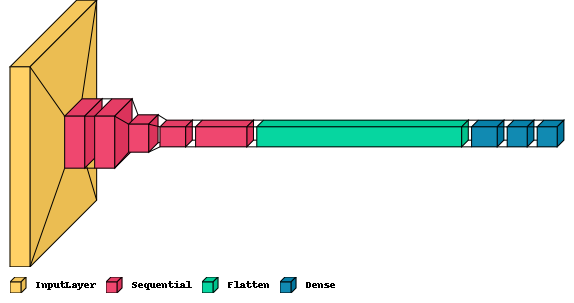

In [38]:
import visualkeras
visualkeras.layered_view(cvae_encoder, legend=True)


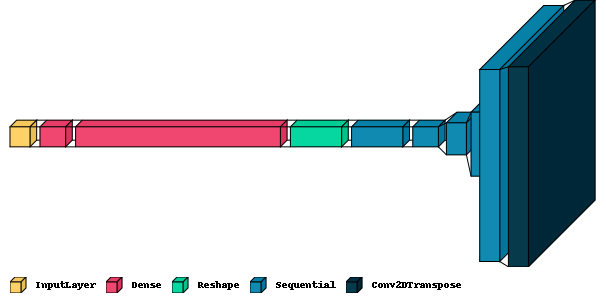

In [39]:
visualkeras.layered_view(cvae_decoder, legend=True)

In [40]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, beta, shape, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.shape = shape
        self.latent_var = []
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_loss_no_weights_tracker = keras.metrics.Mean(name="loss_no_weights")
        #
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_loss")
        self.val_reconstruction_loss_tracker = keras.metrics.Mean(
            name="val_reconstruction_loss")
        self.val_kl_loss_tracker = keras.metrics.Mean(name="val_kl_loss")
        self.val_total_loss_no_weights_tracker = keras.metrics.Mean(name="val_loss_no_weights")
        self.latent_var_tracker = keras.metrics.Mean(name="latent_var") #added
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_total_loss_tracker,
            self.val_reconstruction_loss_tracker,
            self.val_kl_loss_tracker,
            self.total_loss_no_weights_tracker,
            self.val_total_loss_no_weights_tracker,
            self.latent_var_tracker,

        ]
       
    def call(self, inputs):
        _, input_label, conditional_input = self.conditional_input(inputs)
        z_mean, z_log_var = self.encoder(conditional_input)
        z_cond = self.sampling(z_mean, z_log_var, input_label)
        return self.decoder(z_cond)

  
    def conditional_input(self, inputs, label_size=10):
        image_size = [self.shape[0], self.shape[1], self.shape[2]]
        input_img = layers.InputLayer(input_shape=image_size,
                                    dtype ='float32')(inputs[0])
        input_label = layers.InputLayer(input_shape=(label_size, ),
                                        dtype ='float32')(inputs[1])
        labels = tf.reshape(inputs[1], [-1, 1, 1, label_size])
        labels = tf.cast(labels, dtype='float32')
        ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size])
        labels = ones * labels

        conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
        return  input_img, input_label, conditional_input

    def sampling(self, z_mean, z_log_var, input_label):
        if len(input_label.shape) == 1:
            input_label = np.expand_dims(input_label, axis=0)

        eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32,
                               mean=0., stddev=1.0, name='epsilon')
        z = z_mean + tf.exp(z_log_var / 2) * eps
        z_cond = tf.concat([z, input_label], axis=1)
        return z_cond


    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            print(data[1].shape)
            input_img, input_label, conditional_input = self.conditional_input(data)
            batch_size = input_img.shape[0]
            print('batch_size', batch_size)
            z_mean, z_log_var = self.encoder(conditional_input)
            z_cond = self.sampling(z_mean, z_log_var, input_label)
            reconstruction = self.decoder(z_cond)

            #reconstruction_loss = np.prod(self.shape) * tf.keras.losses.MSE(tf.keras.backend.flatten(input_img),
            #                        tf.keras.backend.flatten(reconstruction))
            reconstruction_loss = tf.reduce_sum(
                 keras.losses.MSE(input_img, # removed np.prod(self.shape) *
                                    reconstruction), axis=(1, 2))            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean)
                      - tf.exp(z_log_var))

            kl_loss = tf.reduce_sum(kl_loss, axis=1) #sum over encoded dimensiosn, average over batch
            total_loss_no_weights = reconstruction_loss + kl_loss
            total_loss_no_weights = tf.reduce_mean(total_loss_no_weights)
            kl_loss = self.beta * kl_loss
            total_loss = reconstruction_loss + kl_loss
            total_loss = tf.reduce_mean(total_loss) 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_no_weights_tracker.update_state(total_loss_no_weights)
        self.latent_var_tracker.update_state(z_log_var)
        #wandb.log({"loss": total_loss, "reconstructon_loss": reconstruction_loss, "kl_loss": kl_loss,})
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "loss_no_weights": self.total_loss_no_weights_tracker.result(),
            "latent_var": self.latent_var_tracker.result()
        }


    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        input_img, input_label, conditional_input = self.conditional_input(data)
        z_mean, z_log_var = self.encoder(conditional_input)
        z_cond = self.sampling(z_mean, z_log_var, input_label)
        reconstruction = self.decoder(z_cond)
        reconstruction_loss = tf.reduce_sum(
                 keras.losses.MSE(input_img,
                                    reconstruction), axis=(1, 2))   
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean)
                  - tf.exp(z_log_var))
        kl_loss = tf.reduce_sum(kl_loss, axis=1)
        total_loss_no_weights = reconstruction_loss + kl_loss
        total_loss_no_weights = tf.reduce_mean(total_loss_no_weights)
        kl_loss = self.beta * kl_loss
        total_loss =  reconstruction_loss + kl_loss
        total_loss = tf.reduce_mean(total_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_no_weights_tracker.update_state(total_loss_no_weights)
        return{
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
            "loss_no_weights": self.total_loss_no_weights_tracker.result()
        }


In [41]:
#kl_coefficient = encoded_dim / (input_shape[0] * input_shape[1] * input_shape[2])
kl_coefficient = 1
print('kl coefficient: {:.3f}'.format(kl_coefficient))
# from b vae paper, use beta = encoded_dimension / pixel_dimension i.e. -> 0.068
cvae = CVAE(cvae_encoder, cvae_decoder, kl_coefficient, input_shape)
cvae.built = True
cvae.summary()

kl coefficient: 1.000
Model: "cvae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        [(None, 128),             11765888  
                              (None, 128)]                       
                                                                 
 model_2 (Functional)        (None, 50, 50, 3)         14250691  
                                                                 
Total params: 26,016,597
Trainable params: 26,013,635
Non-trainable params: 2,962
_________________________________________________________________


In [42]:
def conditional_input(self, inputs, label_size=10): 
    print('ones_dim', inputs[0].shape[0])
    image_size = [self.shape[0], self.shape[1], self.shape[2]]

    input_img = layers.InputLayer(input_shape=image_size,
                                    dtype ='float32')(inputs[0])
    input_label = layers.InputLayer(input_shape=(label_size, ),
                                    dtype ='float32')(inputs[1])
    print('image_size:', image_size)

    labels = tf.reshape(inputs[1], [-1, 1, 1, label_size])
    labels = tf.cast(labels, dtype='float32')
    print('labels dim:', labels.shape)

    ones = tf.ones([batch_size] + image_size[0:-1] + [label_size]) 
    labels = ones * labels
    print('labels dim:', labels.shape)
    conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
    return  input_img, input_label, conditional_input

In [43]:
cvae_input = cvae.encoder.input[0]
cvae_output = cvae.decoder.output
mu = cvae.encoder.get_layer('mu').output
log_var = cvae.encoder.get_layer('log_var').output

learning_rate = 0.0001

opt = keras.optimizers.Adam(learning_rate = learning_rate)
cvae.compile(optimizer = opt)
#cvae.compile(optimizer='adam')

In [44]:
inputs = [train_x[:32], train_y_one_hot[:32]]
image_size = [28, 28, 1]
label_size = 10

input_img = layers.InputLayer(input_shape=image_size,
                                dtype ='float32')(inputs[0])
print('input_img:', input_img.shape)
input_label = layers.InputLayer(input_shape=(label_size, ),
                                dtype ='float32')(inputs[1])
print('input_label:', input_label.shape)

labels = tf.reshape(inputs[1], [-1, 1, 1, label_size])
print('labels_1:', labels.shape)

labels = tf.cast(labels, dtype='float32')
print('labels_2:', labels.shape)

ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size]) 
print('ones:', ones.shape)
labels = ones * labels
#labels = labels[:, :, :, :1]
print('labels_ones:', labels.shape)

conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
conditional_input.shape


input_img: (32, 28, 28, 1)
input_label: (32, 10)
labels_1: (32, 1, 1, 10)
labels_2: (32, 1, 1, 10)
ones: (32, 28, 28, 10)
labels_ones: (32, 28, 28, 10)


TensorShape([32, 28, 28, 11])

In [45]:
train_y_one_hot[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [46]:
tf.reshape(conditional_input[:1, :, :, 9:10], [28,28])

<tf.Tensor: shape=(28, 28), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [47]:
A = np.random.randint(0, 10, size=(3, 3, 1))
B= np.random.randint(0, 10, size=(1, 1, 10))
#print(A)
#print(B)

In [48]:
#C = A * B
#print(C.shape)

In [49]:
input = layers.Input(shape=(40,))
layer1 = layers.Dense(40)(input)
layer2 = layers.Dense( 32 * 32* 3)(layer1)
a = keras.Model(input, layer2)
a.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 3072)              125952    
                                                                 
Total params: 127,592
Trainable params: 127,592
Non-trainable params: 0
_________________________________________________________________


In [50]:
z_mean = np.random.normal(size=(100, 512))
z_log_var =  np.random.normal(size=(100, 512))

kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean)
            - tf.exp(z_log_var))

kl_loss.shape

TensorShape([100, 512])

In [51]:
np.prod(input_shape)

784

In [52]:

kl_loss = tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean)
            - tf.exp(z_log_var)), axis=1) #sum over encoded dimensions
kl_loss.shape

TensorShape([100])

In [53]:
#kl_loss = tf.reduce_sum(kl_loss, axis=1)
#kl_loss.shape

In [54]:
input_img = np.random.normal(size=(100, 32, 32, 3))
reconstruction = np.random.normal(size=(100, 32, 32, 3))

reconstruction_loss = np.prod(input_img.shape) * tf.keras.losses.MSE(tf.keras.backend.flatten(input_img),
                                    tf.keras.backend.flatten(reconstruction)) 

reconstruction_loss

<tf.Tensor: shape=(), dtype=float64, numpy=614645.561131235>

In [55]:
K.eval(tf.Variable(reconstruction_loss))

614645.561131235

In [56]:

reconstruction_loss = tf.reduce_sum(

                keras.losses.MSE(input_img,
                                    reconstruction), axis=(1, 2))

reconstruction_loss.shape


TensorShape([100])

In [57]:
kl_loss = kl_coefficient * kl_loss
total_loss =  reconstruction_loss + kl_loss
total_loss = tf.reduce_mean(total_loss)


## **Training**

In [58]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [59]:
epoch_count = 100
batch_size = 100

In [60]:
train_x.shape

(50000, 28, 28, 1)

In [61]:
# Directory
directory = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_{}_{}_ndim:{}_kl:{:.3f}_epoch:{}_batch:{}".format(cvae.name, 
             dataset_name, encoded_dim, kl_coefficient, epoch_count, batch_size)
  
# Parent Directory path
parent_dir = "reports"
  
# Path
path = os.path.join(parent_dir, directory)
  
# Create the directory
# 'GeeksForGeeks' in
# '/home / User / Documents'
os.mkdir(path)
print("Directory '%s' created" %directory)

os.mkdir(path + '/activations')
os.mkdir(path + '/filters')

Directory '20220707-014832_cvae_mnist_ndim:128_kl:1.000_epoch:100_batch:100' created


In [62]:
import wandb
from wandb.keras import WandbCallback
#wandb.init(project="my-test-project", entity="nrderus")

In [63]:
patience = 5


wandb.init(project="HistoDL", entity="nrderus",
  config = {
  "dataset": dataset_name,
  "model": "CVAE",
  "encoded_dim": encoded_dim,
  "kl_coefficient": kl_coefficient,
  "learning_rate": learning_rate,
  "epochs": epoch_count,
  "batch_size": batch_size,
  "patience": patience,
  
})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nrderus. Use `wandb login --relogin` to force relogin


In [64]:

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
             patience=patience, restore_best_weights=True)

history = cvae.fit([train_x,train_y_one_hot],
                   validation_data=([val_x,val_y_one_hot],None),
                   epochs=epoch_count,
                   batch_size=batch_size,
                   callbacks=[early_stop, WandbCallback(save_weights_only=True)  ])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
(100, 10)
batch_size 100


ValueError: in user code:

    File "/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_24104/650161473.py", line 78, in train_step
        z_mean, z_log_var = self.encoder(conditional_input)
    File "/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 50, 50, 3), found shape=(100, 28, 28, 11)


In [ ]:
#K.get_value(cvae.latent_var[0])

In [ ]:
#tf.numpy_function(cvae.latent_var[0], tf.float32)

In [ ]:
plot_history(history)

In [ ]:
# Train_Val_Plot(history.history['loss'][1:],
#                history.history['val_loss'][1:],
#                history.history['reconstruction_loss'][1:],
               
#                history.history['val_reconstruction_loss'][1:],
#                history.history['kl_loss'][1:],
#                history.history['val_kl_loss'][1:]
#                )


In [ ]:
#%tensorboard --logdir logs

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

In [ ]:
#forward the port 6006 on server on 12006 on  my machine
# ssh -N -L 16006:127.0.0.1:6006 nicolas.derus2@137.204.48.211
# access with http://127.0.0.1:16006

In [ ]:
test_loss = cvae.evaluate([test_x, test_y_one_hot],None,
            batch_size=batch_size,verbose=0)
print('Test loss: {:.3f}'.format(test_loss[2]))

## **Embdedding**

In [ ]:

label_size = 10
_, input_label_train, train_input = cvae.conditional_input([train_x, train_y_one_hot])
_, input_label_test, test_input = cvae.conditional_input([test_x, test_y_one_hot])
_, input_label_val, val_input = cvae.conditional_input([val_x, val_y_one_hot])


print(input_label_train.shape)
print(train_input.shape)

In [ ]:
train_x_mean, train_log_var = cvae.encoder.predict(train_input)
test_x_mean, test_log_var = cvae.encoder.predict(test_input)
val_x_mean, val_log_var = cvae.encoder.predict(val_input)

print(train_x_mean.shape)
print(train_log_var.shape)

In [ ]:
if encoded_dim > 2:
    from sklearn import manifold
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    train_x_tsne = tsne.fit_transform(train_x_mean[:2000])
    test_x_tsne = tsne.fit_transform(test_x_mean[:2000])
    val_x_tsne = tsne.fit_transform(val_x_mean[:2000])
    plot_2d_data( [train_x_tsne, test_x_tsne, val_x_tsne],
            [train_y[:2000], test_y[:2000] ,val_y[:2000]],
            ['Train','Test', 'Validation'],(18,6))
    plot_2d_data_categorical( [train_x_mean, test_x_mean, val_x_mean],
            [train_y, test_y ,val_y],
            ['Train','Test', 'Validation'],(12,36))

In [ ]:
if encoded_dim == 2:
    plot_2d_data( [train_x_mean, test_x_mean, val_x_mean],
                [train_y, test_y ,val_y],
                ['Train','Test', 'Validation'],(18,6))
    plot_2d_data_categorical( [train_x_mean, test_x_mean, val_x_mean],
                [train_y, test_y ,val_y],
                ['Train','Test', 'Validation'],(12,36))

## **Reconstruction**

In [ ]:
#reconstructions...
z_cond_train = sampling(train_x_mean, train_log_var, input_label_train)
z_cond_test = sampling(test_x_mean, test_log_var, input_label_test)
z_cond_val = sampling(val_x_mean, val_log_var, input_label_val)

In [ ]:
reconstruction_train = cvae.decoder(z_cond_train)
reconstruction_test = cvae.decoder(z_cond_test)
reconstruction_val = cvae.decoder(z_cond_val)

In [ ]:
random_idx = random.randint(0, reconstruction_train.shape[0])
random_idx

In [ ]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


In [ ]:
image_count = 10

fig, axs = plt.subplots(2, image_count, figsize=(12, 3))
for i in range(image_count):
  random_idx = random.randint(0, reconstruction_train.shape[0])
  axs[0, i].imshow(train_x[random_idx])
  axs[0, i].axis('off')
  #axs[0, i].set_title(train_y[random_idx])
  axs[0, i].set_title( labels[int(train_y[random_idx])]  )
  axs[1, i].imshow(reconstruction_train[random_idx])
  axs[1, i].axis('off')
wandb.log({"Reconstructions": wandb.Image(plt)})


In [ ]:
(cvae.latent_var)

## **Generation**

In [ ]:
def reparametrization(z_mean, z_log_var, input_label):
    """ Performs the riparametrization trick"""

    eps = tf.random.normal(shape = (input_label.shape[0], encoded_dim),
                             mean = 0.0, stddev = 1.0)       
    z = z_mean + tf.math.exp(z_log_var * .5) * eps
    z_cond = tf.concat([z, input_label], axis=1) # (batch_size, label_dim + latent_dim)

    return z_cond

In [ ]:
digit_label = 3
digit_label_one_hot = to_categorical(digit_label, category_count).reshape(1,-1)
a = tf.convert_to_tensor(digit_label_one_hot)
b = tf.concat([a, a], axis=0) # with 1 dimension, it fails...
b.shape

In [ ]:
z_cond = reparametrization(z_mean=0, z_log_var=0.2, input_label = b)
decoded_x = cvae_decoder.predict(z_cond)
digit = decoded_x[0].reshape(input_shape) 
plt.axis('off')
plt.imshow(digit)

In [ ]:
digit_label = 2
_, axs = plt.subplots(2, image_count, figsize=(12, 3))
for i in range(image_count):
    digit_label_one_hot = to_categorical(digit_label, category_count).reshape(1,-1)
    a = tf.convert_to_tensor(digit_label_one_hot)
    b = tf.concat([a, a], axis=0) # with 1 dimension, it fails...
    z_cond = reparametrization(z_mean=0, z_log_var=0.3, input_label = b)
    decoded_x = cvae_decoder.predict(z_cond)
    digit_0 = decoded_x[0].reshape(input_shape) 
    digit_1 = decoded_x[1].reshape(input_shape) 
    axs[0, i].imshow(digit_0)
    axs[0, i].axis('off')
    #axs[0, i].set_title(digit_label)
    axs[0, i].set_title( labels[digit_label]  )
    axs[1, i].imshow(digit_1)
    axs[1, i].axis('off')
    axs[1, i].set_title( labels[digit_label]  )
wandb.log({"Generations": wandb.Image(plt)})

In [ ]:
def generations_class(digit_label=1):
    _, axs = plt.subplots(2, image_count, figsize=(12, 3))
    for i in range(image_count):
        digit_label_one_hot = to_categorical(digit_label, category_count).reshape(1,-1)
        a = tf.convert_to_tensor(digit_label_one_hot)
        b = tf.concat([a, a], axis=0) # with 1 dimension, it fails...
        z_cond = reparametrization(z_mean=0, z_log_var=0.3, input_label = b)
        decoded_x = cvae_decoder.predict(z_cond)
        digit_0 = decoded_x[0].reshape(input_shape) 
        digit_1 = decoded_x[1].reshape(input_shape) 
        axs[0, i].imshow(digit_0)
        axs[0, i].axis('off')
        #axs[0, i].set_title(digit_label)
        axs[0, i].set_title( labels[digit_label]  )
        axs[1, i].imshow(digit_1)
        axs[1, i].axis('off')
        axs[1, i].set_title( labels[digit_label]  )
        wandb.log({"Generations: {}".format(digit_label): wandb.Image(plt)})

    

In [ ]:
label_size = category_count
if (label_size <= 10):
    for i in range(label_size):
        generations_class(i)

In [ ]:
cvae.save_weights('weights/cvae_toy.h5')
cvae_encoder.save('models/cvae_encoder_toy.h5')
cvae_decoder.save('models/cvae_decoder_toy.h5')

In [ ]:
def latent_space_interpolation(digit_label=1):
  n = 10 # number of images per row and column
  limit=3 # random values are sampled from the range [-limit,+limit]
  digit_label_one_hot = to_categorical(digit_label, category_count).reshape(1,-1)
  a = tf.convert_to_tensor(digit_label_one_hot)
  grid_x = np.linspace(-limit,limit, n) 
  grid_y = np.linspace(limit,-limit, n)

  generated_images=[]
  for i, yi in enumerate(grid_y):
    single_row_generated_images=[]
    for j, xi in enumerate(grid_x):
      random_sample = np.array([[xi, yi]])
      digit_label_one_hot = to_categorical(digit_label, category_count).reshape(1,-1)
      a = tf.convert_to_tensor(digit_label_one_hot)
      b = tf.concat([a, a], axis=0) # with 1 dimension, it fails...
      z_cond = reparametrization(z_mean=random_sample, z_log_var=0.0, input_label = b)
      decoded_x = cvae.decoder.predict(z_cond)
      single_row_generated_images.append(decoded_x[0].reshape(original_image_shape))
    generated_images.append(single_row_generated_images)      
  plot_generated_images(generated_images,n,n,True)

In [ ]:
label_size = category_count
if (encoded_dim == 2 & label_size <= 10):
    for i in range(label_size):
        latent_space_interpolation(i)

In [ ]:
#cvae.built = True
#cvae.load_weights('weights/vae_toy.h5')

In [ ]:
wandb.finish(exit_code=0, quiet = True) # TEMPORARY

# **Visualize activation functions**

In [ ]:
def visualize_activations(model):
    test = test_x[1]
    plt.imshow(test)
    #test = image.img_to_array(test)
    test = np.expand_dims(test, axis=0)
    test.shape
    test_label = test_y_one_hot[0]
    img_tensor = [test, test_label]
    from keras import models

    # Extracts the outputs of the top 8 layers:
    import tensorflow as tf

    layer_outputs = []
    layer_names = []
    for layer in model.layers[1:]:
        
        try: 
            layer_outputs.append(layer.get_output_at(1))
            layer_names.append(layer.name)
        
        except:
            layer_outputs.append(layer.output)
            layer_names.append(layer.name)

    # Creates a model that will return these outputs, given the model input:
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    
    # This will return a list of 5 Numpy arrays:
    # one array per layer activation
    if 'encoder' in model.name:
        input_img, input_label, conditional_input = cvae.conditional_input(img_tensor)
        activations = activation_model.predict(conditional_input) #for encoder

    if 'decoder' in model.name:
        input_img, input_label, conditional_input = cvae.conditional_input(img_tensor)
        input_label = np.expand_dims(input_label, axis=0)
        z_mean, z_log_var = cvae.encoder(conditional_input)
        z_cond = cvae.sampling(z_mean, z_log_var, input_label)
        
        activations = activation_model.predict(z_cond) #for decoder
    
    for activation, name in zip(activations[0:], layer_names[0:]):
        print(name)
        print(activation.shape)
    
    for counter, (activation, name) in enumerate(zip(activations[0:], layer_names[0:])):
        print(name)
        plot_filters(activation, name, counter, model_name=model.name)
            

In [ ]:
test = test_x[1]
plt.imshow(test)
#test = image.img_to_array(test)
test = np.expand_dims(test, axis=0)
test.shape
test_label = test_y_one_hot[0]
img_tensor = [test, test_label]
input_img, input_label, conditional_input = cvae.conditional_input(img_tensor)

In [ ]:
print(input_img.shape)
print(input_label.shape)
print(conditional_input.shape)

In [ ]:
inputs = [input_img, input_label]
image_size = [28, 28, 1]
input_img = layers.InputLayer(input_shape=image_size,
                            dtype ='float32')(inputs[0])
input_label = layers.InputLayer(input_shape=(label_size, ),
                                dtype ='float32')(inputs[1])


In [ ]:
labels = tf.reshape(inputs[1], [-1, 1, 1, label_size])
print(labels)
labels = tf.cast(labels, dtype='float32')
print(labels)
ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size])
print(ones.shape)
labels = ones * labels 
print(labels)
conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 

In [ ]:
import math
def plot_filters(activation_layer, layer_name, counter, model_name):
    if len(activation_layer.shape) == 2: # if flat layer
        print('flat')
        return None
        if activation_layer.shape[1] == 1875:
            activation_layer = activation_layer.reshape(1, 25, 25, 3)
        if activation_layer.shape[1] == 1024:
           activation_layer = activation_layer.reshape(1, 16, 16, 4)
        if activation_layer.shape[1] == 512:
           activation_layer = activation_layer.reshape(1, 8, 8, 8)

    n = math.floor(np.sqrt(activation_layer.shape[3]))

    if int(n + 0.5) ** 2 == activation_layer.shape[3]:

        m = n
    else:
        m = math.floor(activation_layer.shape[3] / n)

    if activation_layer.shape[3] == 1:
        fig, ax = plt.subplots(1, 1, sharex='col', sharey='row',
                                figsize=(15, 15))
        fig.suptitle(layer_name)

        ax.imshow(activation_layer[0,:, :, 0], cmap='viridis')
        wandb.log({"Activations": wandb.Image(plt, caption="{}_{}".format(model_name, layer_name)) })
        fig.savefig("reports/" + directory + '/activations/{}_{}_activations_{}.png'.format(model_name,
                     counter, layer_name))
        return None   

            
    if n == 1:

        fig, ax = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(15, 15))
        fig.suptitle(layer_name)
        for i in range(3):
            ax[i].imshow(activation_layer[0,:, :, i], cmap='viridis')
        wandb.log({"Activations": wandb.Image(plt, caption="{}_{}".format(model_name, layer_name)) })
        fig.savefig("reports/" +directory +'/activations/{}_{}_activations_{}.png'.format(model_name, counter, layer_name))
        return None   

    fig, ax = plt.subplots(n, m, sharex='col', sharey='row',figsize=(15, 15))
    fig.suptitle(layer_name)
    
 

    filter_counter = 0
    for i in range(n):
        for j in range(m):
            ax[i, j].imshow(activation_layer[0,:, :, filter_counter], cmap='viridis')
            filter_counter += 1
            if filter_counter == (activation_layer.shape[3] ):
                break

    wandb.log({"Activations": wandb.Image(plt, caption="{}_{}".format(model_name, layer_name)) })
    fig.savefig("reports/" + directory + "/activations/{}_{}_activations_{}.png".format(model_name, counter, layer_name))
    return None

In [ ]:
visualize_activations( cvae.encoder)
visualize_activations(cvae.decoder)

# **Visualize filters**

In [ ]:
model = cvae.encoder

In [ ]:
# util function to convert a tensor into a valid image
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    #img = img[ 25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img



In [ ]:
def filter_conditional_input( inputs, label_size=10): 
  
        image_size = [input_shape[0], input_shape[1], input_shape[2]]

        input_img = layers.InputLayer(input_shape=image_size,
                                        dtype ='float32')(inputs[0])
        input_label = layers.InputLayer(input_shape=(label_size, ),
                                        dtype ='float32')(inputs[1])

        labels = tf.reshape(inputs[1], [-1, 1, 1, label_size])
        labels = tf.cast(labels, dtype='float32')
        ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size]) 
        labels = ones * labels
        conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
        return  input_img, input_label, conditional_input


In [ ]:
def build_nth_filter_loss(filter_index, layer_name):
    """
    We build a loss function that maximizes the activation
    of the nth filter of the layer considered
    """

    # Create a connection between the input and the target layer
    
    submodel = tf.keras.models.Model([model.inputs[0]],
                                     [model.get_layer(layer_name).output])

# Initiate random noise

    input_img_data = np.random.random((1, input_shape[0], input_shape[1],
                                     input_shape[2]))

    input_img_data =(input_img_data - 0.5) * 0.25
    # Cast random noise from np.float64 to tf.float32 Variable
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    data = [input_img_data, train_y_one_hot[0]]
    _, _, conditional_input_img = filter_conditional_input(data) 
    conditional_input_img= tf.Variable(tf.cast(conditional_input_img,
                                         tf.float32))

    for _ in range(epochs):
        with tf.GradientTape() as tape:
            outputs = submodel(conditional_input_img)
            loss_value = tf.reduce_mean(outputs[:, 2:-2, 2:-2, filter_index]) #removed borders in loss
        grads = tape.gradient(loss_value, conditional_input_img)
        normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads)))
                                   + 1e-5)
        #normalized_grads = tf.math.l2_normalize(grads)
        conditional_input_img.assign_add(normalized_grads * step_size)

    # this function returns the loss and grads given the input picture
    #iterate = K.function([input_img], [loss_value, grads])

    if loss_value > 0:
        
        #img = conditional_input_img.numpy().astype(np.float64)
        #img = img.squeeze()
        #img = deprocess_image(img) / 255.
        img = conditional_input_img.numpy().astype(np.float64)
        img = img.squeeze()
        img = deprocess_image(img)
        kept_filters.append((img, loss_value))


In [ ]:
#dimensions of the generated pictures for each filter.
img_width = input_shape[0]
img_height = input_shape[1]

# this is the placeholder for the input images
input_img = model.input
print(input_img.shape)

# get the symbolic outputs of each "key" layer (we gave them unique names).
#layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layer_dict

In [ ]:
layers_filters = [layer.name for layer in model.layers]

In [ ]:
epochs = 30
step_size = 10.
kept_filters = []
filters_dict = dict()
for layer_name in layers_filters:
    if 'conv' in layer_name:
        layer = model.get_layer(layer_name)
        print('Processing filter for layer:', layer_name)
        for filter_index in range(min(layer.output.shape[-1], 100)):
            # print('Processing filter %d' % filter_index)
            build_nth_filter_loss(filter_index, layer_name)
        filters_dict[layer.name] = kept_filters
        kept_filters = []

In [ ]:
from keras.preprocessing.image import save_img

def stich_filters(kept_filters, layer_name):
    # By default, we will stich the best 64 (n*n) filters on a 8 x 8 grid.
    n = int(np.sqrt(len(kept_filters)))
    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:n * n]

    # build a black picture with enough space for
    # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
    margin = 5
    
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin

    stitched_filters = np.zeros((width, height, 3))

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, _ = kept_filters[i * n + j]
            width_margin = (img_width + margin) * i
            height_margin = (img_height + margin) * j
            stitched_filters[
                width_margin: width_margin + img_width,
                height_margin: height_margin + img_height, :] = img[:, :, :3] 

    wandb.log({"Filters": wandb.Image(stitched_filters, caption="{}_{}".format(model.name, layer_name)) })
    # save the result to disk
    save_img("reports/" +directory + '/filters/{}_stitched_filters_{}.png'.format(model.name,
             layer_name), stitched_filters)
    

In [ ]:
for layer_name, kept_filters in filters_dict.items():
    print('Stiching filters for {}'.format(layer_name))
    stich_filters(kept_filters, layer_name)
    print('number of filters kept:', len(kept_filters))
    print('Completed.')

In [ ]:
wandb.finish(exit_code=0, quiet = True)

In [ ]:
#from src.cvae import CVAE
#CVAE(cvae_encoder, cvae_decoder, kl_coefficient, input_shape)

# **Report activations**

In [ ]:
from fpdf import FPDF
import os
# create a instance of fpdf
pdf = FPDF(format='A4')
pdf.set_margins(0., 0.,  0.)
pdf.set_auto_page_break(0)
# use a folder that you created (here it's imgs)
img_list = [x for x in os.listdir("reports/" + directory + "/activations")] 
img_list = sorted(img_list, key=lambda x: int(x.split('_')[1]))
# add new pages with the image 
for img in img_list:
    pdf.add_page()
    pdf.image("reports/" + directory + "/activations/"+img, y=50, w=200, h=200)
# save the output file
pdf.output("reports/" + directory +"/report_activations.pdf")
print("Adding all your images into a pdf file")
print("Images pdf is created and saved it into the following path folder:\n",
      os.getcwd())

# **Report filters**

In [ ]:
# create a instance of fpdf
pdf = FPDF(format='A4')
pdf.set_margins(30., 0.,  0.)
pdf.set_auto_page_break(0)
# use a folder that you created (here it's imgs)
img_list = [x for x in os.listdir("reports/" + directory + "/filters")] 
img_list = sorted(img_list)
# add new pages with the image 
for img in img_list:
    pdf.add_page()
    pdf.image("reports/" + directory + "/filters/"+img, y=75, w=150, h=150)
# save the output file
pdf.output("reports/" + directory +"/report_filters.pdf")
print("Adding all your images into a pdf file")
print("Images pdf is created and saved it into the following path folder:\n",
      os.getcwd())

# **Report**

In [ ]:
# create a instance of fpdf
pdf = FPDF(format='A4')
pdf.set_margins(0., 0.,  0.)
pdf.set_auto_page_break(0)
# use a folder that you created (here it's imgs)
img_list = [x for x in os.listdir("reports/" + directory )] 
img_list = sorted(img_list)
# add new pages with the image 
for img in img_list:
    if 'png' in img:
        pdf.add_page()
        pdf.image("reports/" + directory + '/' +img, w=275, h=300)
# save the output file
pdf.output("reports/" + directory +"/{}.pdf".format(directory))
print("Adding all your images into a pdf file")
print("Images pdf is created and saved it into the following path folder:\n",
      os.getcwd())

In [ ]:
img_list